In [2]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
%matplotlib inline

# import data

In [3]:
training_set = pd.read_csv("Training Set.csv")
training_label = pd.read_csv("Training Set Labels.csv")
data = pd.merge(training_set, training_label, how="left", on="id")

# Drop columns
#feature_list = ['longitude', 'latitude']
feature_list = ['longitude', 'latitude', 'gps_height']
data['population'] = data['population'].apply(lambda x: m.log2(x + 1) if x < 5000 else m.log2(5000))
data['amount_tsh'] = data['amount_tsh'].apply(lambda x: m.log2(x + 1) if x < 5000 else m.log2(5000))

data = data[feature_list]
data = data[data["longitude"] != 0]

print(data.shape)
data.head()

(57588, 3)


,longitude,latitude,gps_height
0,34.938093,-9.856322,1390
1,34.698766,-2.147466,1399
2,37.460664,-3.821329,686
3,38.486161,-11.155298,263
4,31.130847,-1.825359,0


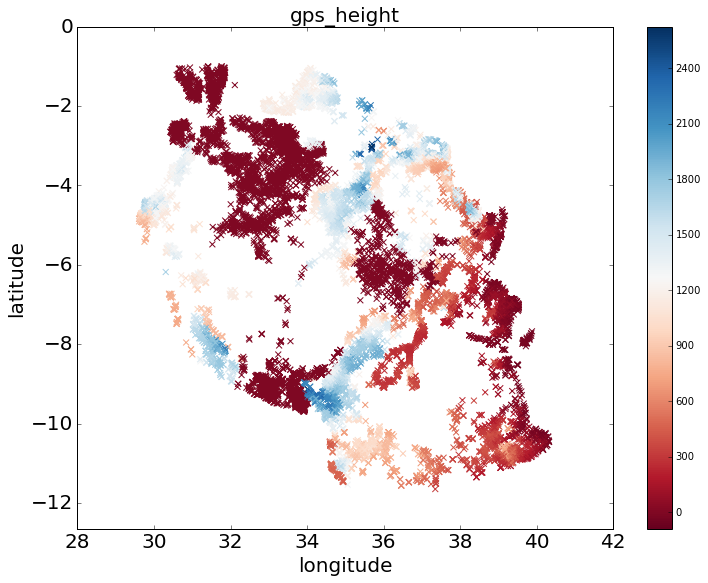

In [4]:
# Plot gps_height
sub_data = data.sample(frac=0.3, replace=False)
x = sub_data['latitude']
y = sub_data['longitude']
z = sub_data['gps_height']

fig = plt.figure(figsize=(12,9))
cm = plt.cm.get_cmap('RdBu')
sc = plt.scatter(y, x, marker='x', c=z, vmin=z.min(), vmax=z.max(), s=35, cmap=cm)
plt.colorbar(sc)
plt.ylim(x.min()-1, x.max()+1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('gps_height', fontsize=20)
plt.xlabel('longitude', fontsize=20)
plt.ylabel('latitude', fontsize=20)
plt.show()

In [5]:
# Plot gps_height
sub_data = data.sample(frac=0.3, replace=False)
x = sub_data['latitude']
y = sub_data['longitude']
z = sub_data['population']

fig = plt.figure(figsize=(12,9))
cm = plt.cm.get_cmap('RdBu')
sc = plt.scatter(y, x, marker='x', c=z, vmin=z.min(), vmax=z.max(), s=35, cmap=cm)
plt.colorbar(sc)
plt.ylim(x.min()-1, x.max()+1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('population', fontsize=20)
plt.xlabel('longitude', fontsize=20)
plt.ylabel('latitude', fontsize=20)
plt.show()

KeyError: 'population'

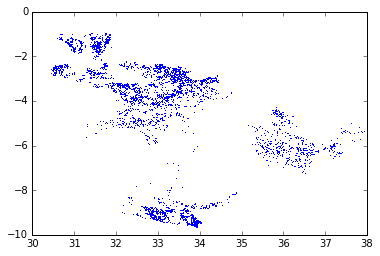

In [6]:
sub_data_0 = sub_data[(sub_data['gps_height'] == 0) & (sub_data['longitude'] < 38)]
plt.plot(sub_data_0['longitude'], sub_data_0['latitude'], ",b")

# k-means clustering

In [7]:
scalar = preprocessing.StandardScaler()
scalar.fit(data)
data = pd.DataFrame(scalar.transform(data), columns=['longitude', 'latitude', 'gps_height'])

In [8]:
# We first use k-means clustering to find some centroids
kmeans = KMeans(n_clusters=50, random_state=0).fit(data)
centroids = kmeans.cluster_centers_

In [10]:
c_longitude, c_latitude = np.zeros(50), np.zeros(50)
ptr = 0
for centroid in centroids:
    c_longitude[ptr] = centroid[0]
    c_latitude[ptr] = centroid[1]
    ptr += 1

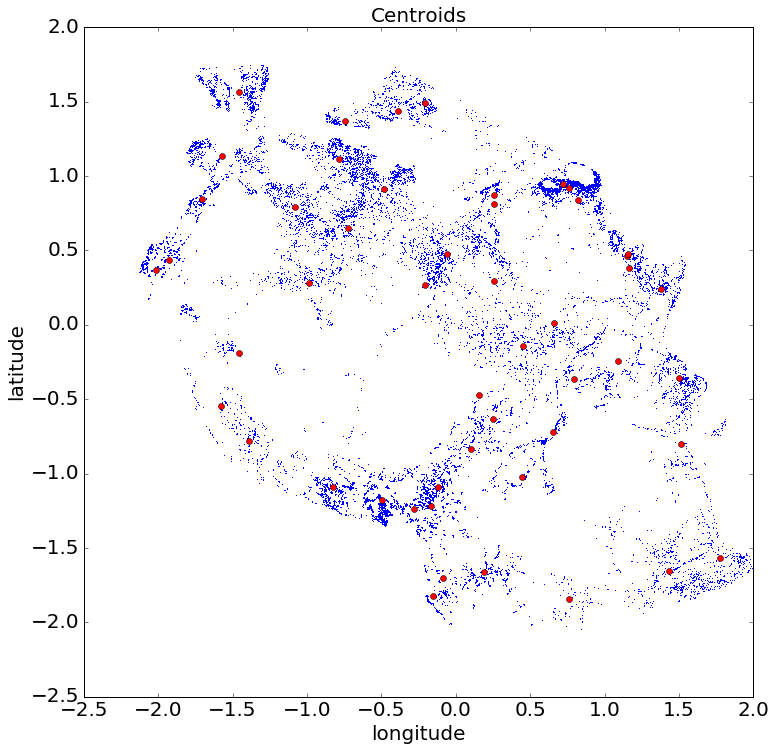

In [11]:
sub_data = data.sample(frac=0.5, replace=False)
fig = plt.figure(figsize=(12,12))
plt.plot(sub_data['longitude'], sub_data['latitude'], ",b", alpha=1)
plt.plot(c_longitude, c_latitude, "or")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Centroids', fontsize=20)
plt.xlabel('longitude', fontsize=20)
plt.ylabel('latitude', fontsize=20)

In [27]:
def find_centroid(longitude, latitude, centroids):
    closest = 0
    centroid = centroids[0]
    min_dis = (longitude - centroid[0])**2 + (latitude - centroid[1])**2 # + (height - centroid[2])**2
    for i in range(1, centroids.shape[0]):
        dis = (longitude - centroids[i][0])**2 + (latitude - centroids[i][1])**2 # + (height - centroid[2])**2
        if dis < min_dis:
            min_dis = dis
            closest = i
            centroid = centroids[i]
    return closest, centroid

In [28]:
i, j = find_centroid(1, -1, centroids)
print(i, j)

1 [ 0.55213756 -0.85294516 -0.55866853]


In [32]:
# Find out which centroid it belongs to 
location_data = data.as_matrix()
which_centroid = np.zeros(data.shape[0])
for i in range(0, data.shape[0]):
    which_centroid[i], dummy = find_centroid(location_data[i][0], location_data[i][1], centroids)
data['which_centroid'] = which_centroid

In [30]:
#data['which_centroid'] = data['which_centroid'].astype(str)
#data['which_centroid'].describe()

count     57588
unique       30
top         0.0
freq       4125
Name: which_centroid, dtype: object

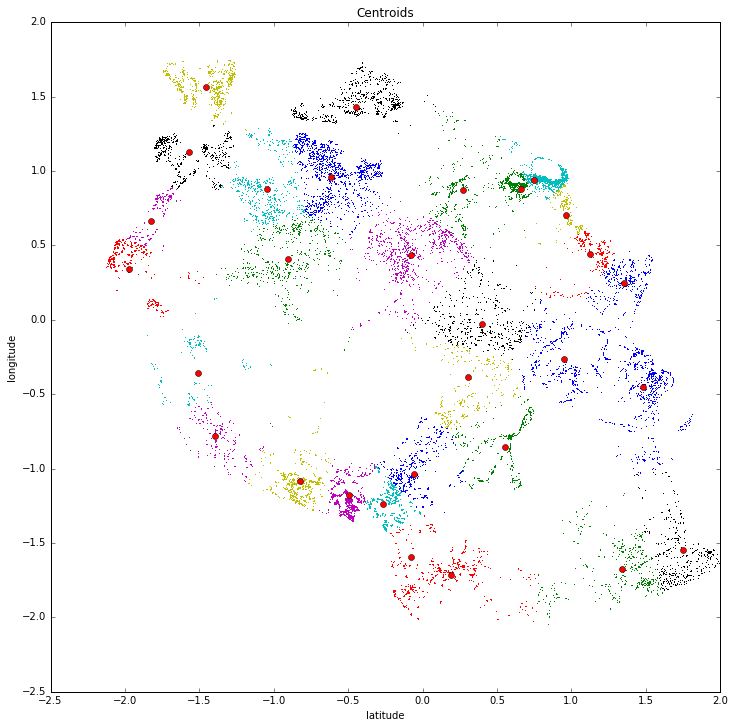

In [33]:
sub_data = data.sample(frac=0.4, replace=False)
fig = plt.figure(figsize=(12,12))
for i in range(0, 30):
    subsub_data = sub_data[sub_data['which_centroid'] == i]
    plt.plot(subsub_data['longitude'], subsub_data['latitude'], ",", alpha=1)
plt.plot(c_longitude, c_latitude, "or")
plt.title("Centroids")
plt.xlabel("latitude")
plt.ylabel("longitude")

In [7]:
# Create new features that decribes the distance to each centroid
count = 1
for centroid in centroids:
    column_name = 'centroid_' + str(count)
    count += 1
    data[column_name] = ((data['longitude'] - centroid[0])**2 + (data['latitude'] - centroid[1])**2).apply(lambda x: m.sqrt(x))

In [8]:
data['centroid_1'].describe()

count    57588.000000
mean         5.367711
std          1.911280
min          0.010249
25%          4.024571
50%          5.431454
75%          7.094564
max          9.125098
Name: centroid_1, dtype: float64

(array([  215.,   232.,   246.,   185.,   202.,    81.,    57.,   278.,
          424.,   654.,   648.,   204.,   600.,   641.,  1222.,  1019.,
          522.,  1389.,  1390.,  1304.,  1422.,  1431.,  1225.,  1425.,
         2183.,  2213.,  2268.,  1415.,  2022.,  2266.,  2455.,  1850.,
          672.,   879.,  1624.,  1198.,  1231.,  1324.,  2811.,  1701.,
         3367.,  3754.,  2271.,  1128.,   671.,   487.,   205.,   223.,
          245.,   109.]),
 array([ 0.01024935,  0.19254632,  0.37484328,  0.55714025,  0.73943721,
         0.92173418,  1.10403114,  1.28632811,  1.46862507,  1.65092204,
         1.833219  ,  2.01551597,  2.19781293,  2.3801099 ,  2.56240686,
         2.74470382,  2.92700079,  3.10929775,  3.29159472,  3.47389168,
         3.65618865,  3.83848561,  4.02078258,  4.20307954,  4.38537651,
         4.56767347,  4.74997044,  4.9322674 ,  5.11456437,  5.29686133,
         5.4791583 ,  5.66145526,  5.84375223,  6.02604919,  6.20834616,
         6.39064312,  6.5729400

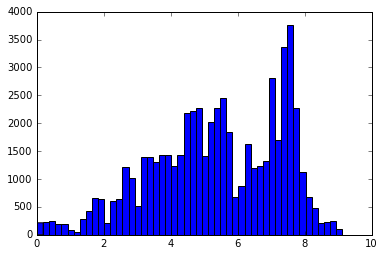

In [10]:
plt.hist(data['centroid_1'], 50)